In [3]:
%load_ext autoreload
%autoreload 2
# You can load your python module as this:
import examproject.example

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Import packages:**

In [68]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

**We define the variables used in the analysis:**

w: wage rate <br>
b: unemployment benefit <br>
$c_t$: consumption in period t <br>
$h_t$: human capital in period t <br>
$l_t$: labor supply in period t <br>
$\rho$: risk aversion coefficient <br>
$\gamma$: degree of disutility from working <br>
$\Delta$: stochastic experience gain <br>
$\beta$: discount factor

**Defining the necessary equations and the values of l.**

In [135]:
l = [0, 1]

def consumption(w,h,b,l):
    """
    If the person doesn't work (l = 0), she will recieve an unemployment benefit (b) instead of a wage income.
    If the person works (l = 1), she will receive a wage income based on the wage (w) and her human capital (h).
    """
    if l == 0:
        c = b
    elif l == 1:
        c = w*h
    return c

def utility(rho,h,w,b,l):
    return consumption(w,h,b,l)**(1-rho)/(1-rho)

def disutility(l,gamma):
    return gamma*l

def v2(l2,h2,w,b,rho,gamma):
    return utility(rho,h2,w,b,l2) - disutility(l2,gamma)

**Setting parameter values:**

In [84]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

In [136]:
def solve_period_2(w,b,rho,gamma):
    """
    The function solves the utility maximizing problem in period 2 for different values of human capital in period 2.
    This is done, by comparing the utility when working to the utility when not working,
    for a given level of human capital and thereby identifying the utility maximizing behavior.
    
    It returns the utility, the labor supply and the consumption for the different values of human capital.
    """
    # a. grids
    h2_vec = np.linspace(0.1,1.5,100)
    l2_vec = np.empty(100)
    c2_vec = np.empty(100)
    v2_vec = np.empty(100)
    
    # b. solve for each h2 in grid
    for i,h2 in enumerate(h2_vec):
        
        # i. Calculating v when working, l[0] and when not working, l[1].
        v2_0 = v2(l[0],h2,w,b,rho,gamma)
        v2_1 = v2(l[1],h2,w,b,rho,gamma)
        
        # ii. Finding the maximum value of v and the value of l and c associated with it, and saving these values.
        v2_vec[i] = max(v2_0,v2_1)
        l2_vec[i] = v2_1 > v2_0
        c2_vec[i] = consumption(w,h2,b,l2_vec[i])
        
    return h2_vec,v2_vec,l2_vec,c2_vec

In [155]:
# solving for period 2 and assigning values to different vectors.
h2_vec,v2_vec,l2_vec,c2_vec = solve_period_2(w,b,rho,gamma);

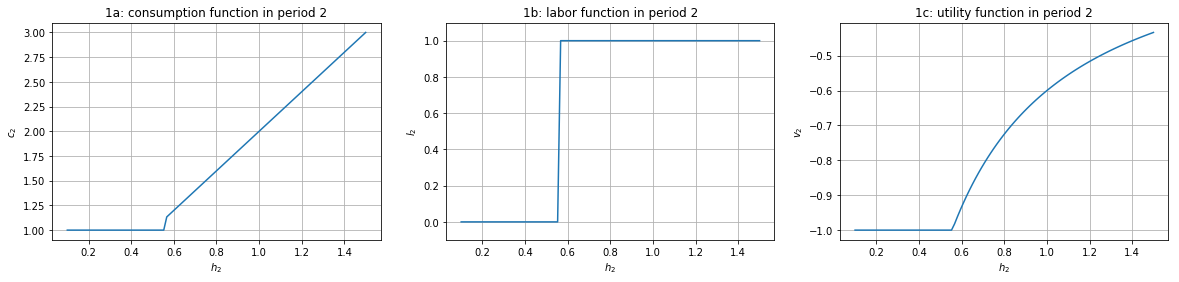

In [157]:
# Presents consumption, labor supply and utility as a function of human capital,
# based on the utility maximizing problem in period 2.
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1,3,1)
ax.plot(h2_vec,c2_vec)
ax.grid()
ax.set_xlabel('$h_2$')
ax.set_ylabel('$c_2$')
ax.set_title('1a: consumption function in period 2')

ax = fig.add_subplot(1,3,2)
ax.plot(h2_vec,l2_vec)
ax.grid()
ax.set_xlabel('$h_2$')
ax.set_ylabel('$l_2$')
ax.set_title('1b: labor function in period 2')
ax.set_ylim([-0.1,1.1])

ax = fig.add_subplot(1,3,3)
ax.plot(h2_vec,v2_vec)
ax.grid()
ax.set_xlabel('$h_2$')
ax.set_ylabel('$v_2$')
ax.set_title('1c: utility function in period 2');

**Identifying the level of human capital necessary for the individual to work:**

In [177]:
index = np.where(l2_vec == 1)[0][0];
print('She chooses to work when h ≥ ' + str(round(h2_vec[index],3)))

She chooses to work when h ≥ 0.567


**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital).

**Construct interpolator:**

In [80]:
# Defining an interpolating function based on data from figure 1c.
v2_interp = interpolate.RegularGridInterpolator([h2_vec], v2_vec, bounds_error=False,fill_value=None)

***Defining $v_1$:*** <br>
We use the interpolated function to define the expected utility in period 2, accounting for two possible scenarios, <br> one scenario with a stochastic experience gain to the human capital in period 2 and one without.

In [81]:
def v1(l1,h1,w,b,rho,gamma,beta,Delta,v2_interp):
    
    # a. v2 value without a stochastic experience gain
    h2_low = h1 + l1
    v2_low = v2_interp([h2_low])[0]
    
    # b. v2 value with a stochastic experience gain
    h2_high = h1 + l1 + Delta
    v2_high = v2_interp([h2_high])[0]
    
    # c. expected value of v2
    v2 = 0.5 * v2_low + 0.5 * v2_high
    
    # d. total value
    return utility(rho,h1,w,b,l1) - disutility(l1,gamma) + beta*v2

In [85]:
def solve_period_1(w,b,rho,gamma,Delta,beta,v2_interp):
    """
    The function solves the intertemporal utility maximizing problem in period 1,
    for different values of human capital in period 1 considering both periods.
    This is done, by comparing the utility when working to the utility when not working,
    for a given level of human capital and thereby identifying the utility maximizing behavior.
    
    It returns the utility, the labor supply and the consumption for the different values of human capital.
    """ 
    # a. grids
    h1_vec = np.linspace(0.1,1.5,100)
    l1_vec = np.empty(100)
    c1_vec = np.empty(100)
    v1_vec = np.empty(100)
    
    # b. solve for each h2 in grid
    for i,h1 in enumerate(h1_vec):
        
        # i. Calculating v when working, l[0] and when not working, l[1].
        v1_0 = v1(l[0],h1,w,b,rho,gamma,beta,Delta,v2_interp)
        v1_1 = v1(l[1],h1,w,b,rho,gamma,beta,Delta,v2_interp)
        
        # ii. Finding the maximum value of v and the value of l and c associated with it, and saving these values.
        v1_vec[i] = max(v1_0,v1_1)
        l1_vec[i] = v1_1 > v1_0
        c1_vec[i] = consumption(w,h1,b,l1_vec[i])
        
    return h1_vec,v1_vec,l1_vec,c1_vec

In [159]:
# solving for period 1 and assigning values to different vectors.
h1_vec,v1_vec,l1_vec,c1_vec = solve_period_1(w,b,rho,gamma,Delta,beta,v2_interp)

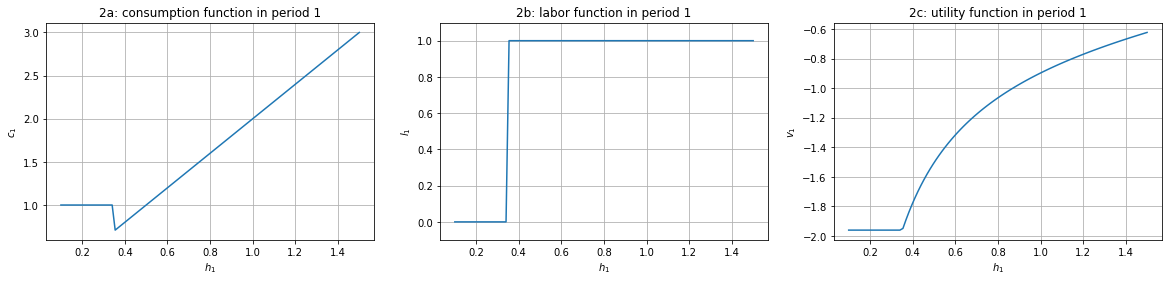

In [160]:
# Presents consumption, labor supply and utility as a function of human capital,
# based on the intertemporal utility maximizing problem in period 1.
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1,3,1)
ax.plot(h1_vec,c1_vec)
ax.grid()
ax.set_xlabel('$h_1$')
ax.set_ylabel('$c_1$')
ax.set_title('2a: consumption function in period 1')

ax = fig.add_subplot(1,3,2)
ax.plot(h1_vec,l1_vec)
ax.grid()
ax.set_xlabel('$h_1$')
ax.set_ylabel('$l_1$')
ax.set_title('2b: labor function in period 1')
ax.set_ylim([-0.1,1.1])

ax = fig.add_subplot(1,3,3)
ax.plot(h1_vec,v1_vec)
ax.grid()
ax.set_xlabel('$h_1$')
ax.set_ylabel('$v_1$')
ax.set_title('2c: utility function in period 1');

**Identifying the level of human capital necessary for the individual to work:**

In [178]:
index = np.where(l1_vec == 1)[0][0];
print('She chooses to work when h ≥ ' + str(round(h1_vec[index],3)))

She chooses to work when h ≥ 0.355


**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

As can be seen in figure 2a the worker will choose to work even though her potential wage income is lower than the unemployment benefit, i.e. her consumption is lower when she chooses to work.
The reason for this, is that she improves her human capital in period 2 by working in period 1. This will then improve her consumption more in period 2 than it reduces her consumption in period 1.